In [1]:
%matplotlib inline

import os

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense

from keras.preprocessing.image import array_to_img, img_to_array, load_img
from scipy.misc import imresize

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.rcParams['font.size'] = 9
plt.rcParams['figure.figsize'] = (12,12)

Using TensorFlow backend.


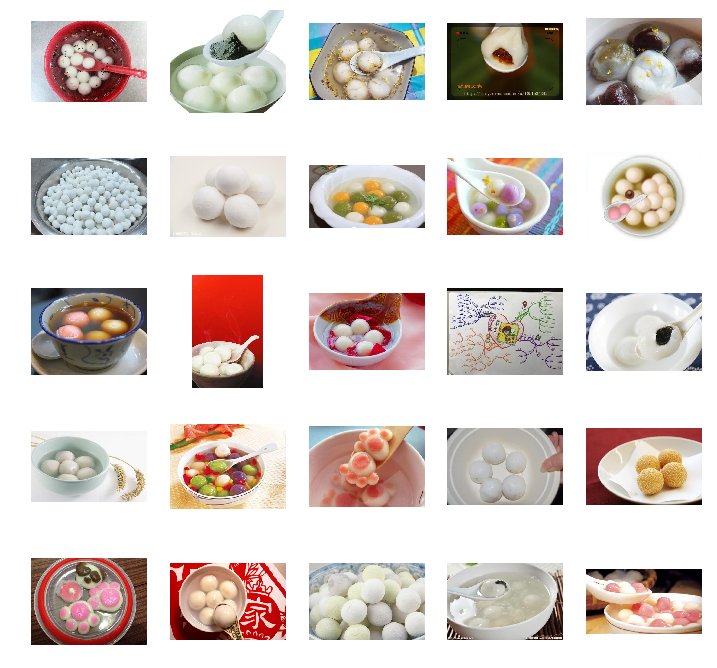

In [2]:
# 显示部分训练数据集的图片

def show_pic(directory):
    some_pics = os.listdir(directory)
    show_rows = show_columns = 5
    for k in range(show_rows * show_rows):
        image = mpimg.imread('%s/%s' % (directory, some_pics[k]))
        plt.subplot(show_rows, show_rows, k+1)
        plt.imshow(image)
        plt.axis('off')
        
show_pic('data/train/tangyuan')

In [3]:
# 定义部分参数

img_width, img_height = 200, 200   # 图片大小

# 训练集目录和验证集目录
train_data_dir = 'data/train'
validation_data_dir = 'data/validation'

# 训练集和验证集样本数
nb_train_samples = 3200
nb_validation_samples = 800

epochs = 25       # 训练轮次
batch_size = 16   # 批训练数  总批数=(样本数/批训练数)*训练轮次

input_shape = (img_width, img_height, 3)    # 输入(图片)的大小, 3 表示图片的颜色通道数(RGB)

In [4]:
# 图片增强, 对于小数据量训练非常有用
# 实际上我们这里训练集只有 1400 张图片
# 而我们上面设置的样本数为 3200
# 通过 Keras 的图片增强功能实现生成新的训练图片
# https://zhuanlan.zhihu.com/p/30197320 这篇文章非常详细地说明了各种图片增强方式

# rescale        对于图片来说一般都需要设置 1./255, 将输入区间限定在 [0,1] 之间
# rotation_range 旋转
# zoom_range     放大
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=30, zoom_range=0.5)

# 验证集只设置 rescale 即可
validation_datagen = ImageDataGenerator(rescale=1./255)

# 通过 ImageDataGenerator.flow_from_directory 定义目录图片生成器, 将从该目录中生成训练图片
# target_size: 图片会自动 resize 成这个大小
# batch_size:  一次生成多少个
# class_mode:  两分类为 binary, 多分类为 categorical
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 1400 images belonging to 2 classes.
Found 800 images belonging to 2 classes.


In [5]:
!mkdir -pv trained_models
!rm trained_models/*.h5

In [6]:
# 设置训练时的 callback 函数, 可以在训练过程中方便处理自定义的操作
# https://keras-cn.readthedocs.io/en/latest/other/callbacks/

# ModelCheckpoint    按照一定的规则保存训练过程中的模型
# ReduceLROnPlateau  当评价指标不再提升时，减少学习率

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
filepath="trained_models/{epoch:02d}-{val_acc:.2f}.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)
callbacks_list = [checkpoint, reduce_learning_rate]

In [7]:
# 搭建卷积神经网络模型

model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 98, 98, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 47, 47, 64)        18496     
__________

In [9]:
# 开始训练

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size,
    callbacks=callbacks_list)

Epoch 1/25
200/200 [==============================] - 71s - loss: 0.7443 - acc: 0.5056 - val_loss: 0.6930 - val_acc: 0.5050
Epoch 2/25
200/200 [==============================] - 30s - loss: 0.6926 - acc: 0.5288 - val_loss: 0.6921 - val_acc: 0.5387
Epoch 3/25
200/200 [==============================] - 30s - loss: 0.6935 - acc: 0.4900 - val_loss: 0.6931 - val_acc: 0.5038
Epoch 4/25
200/200 [==============================] - 30s - loss: 0.6923 - acc: 0.5216 - val_loss: 0.6931 - val_acc: 0.5025
Epoch 5/25
200/200 [==============================] - 30s - loss: 0.6884 - acc: 0.5509 - val_loss: 0.6921 - val_acc: 0.5475
Epoch 6/25
200/200 [==============================] - 30s - loss: 0.6831 - acc: 0.5375 - val_loss: 0.6199 - val_acc: 0.7188
Epoch 7/25
200/200 [==============================] - 30s - loss: 0.6657 - acc: 0.6037 - val_loss: 0.6916 - val_acc: 0.5125
Epoch 8/25
200/200 [==============================] - 30s - loss: 0.6556 - acc: 0.6000 - val_loss: 0.6203 - val_acc: 0.6288
Epoch 9/

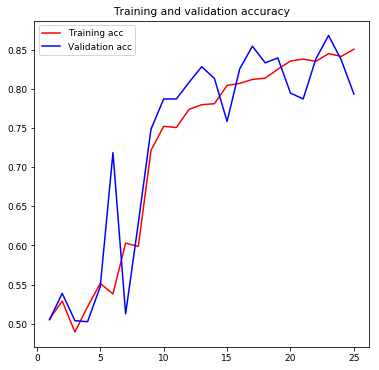

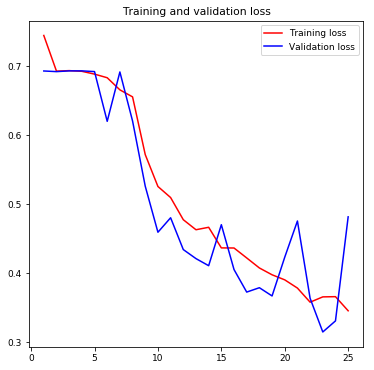

In [10]:
# 绘制 acc 和 loss 指标

plt.rcParams['figure.figsize'] = (6,6)

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'red', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'red', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')
plt.legend()

plt.show()

In [11]:
# 导入训练过程中 val_acc 最高 (可以认为效果最好) 的模型

from keras.models import load_model
best_model = load_model('trained_models/22-0.87.h5')

In [12]:
# 测试集的图片生成器

datagen = ImageDataGenerator(rescale=1./255)
test_generator = datagen.flow_from_directory(
        'data/test',
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 200 images belonging to 2 classes.


In [13]:
# 测试集效果 [loss, acc]

scores = best_model.evaluate_generator(
        test_generator,
        steps=200)
scores

[0.27039953657946031, 0.87532467532467528]

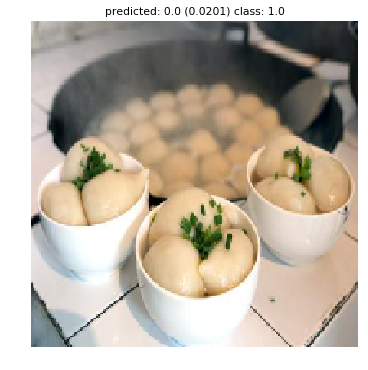

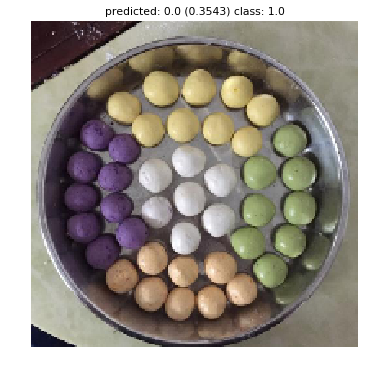

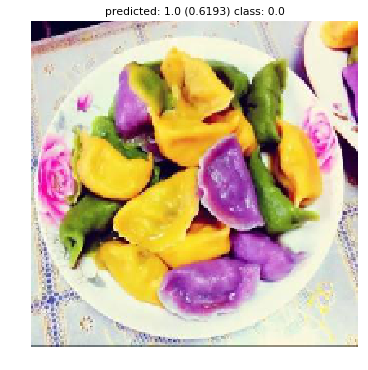

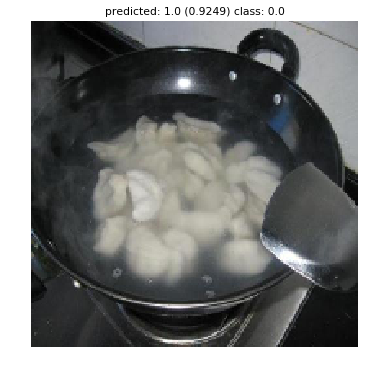

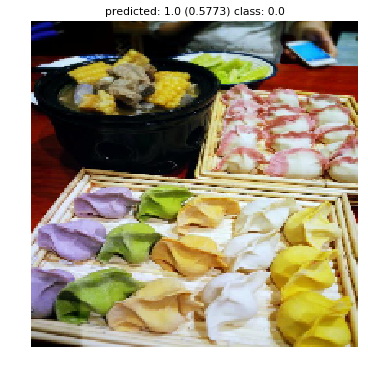

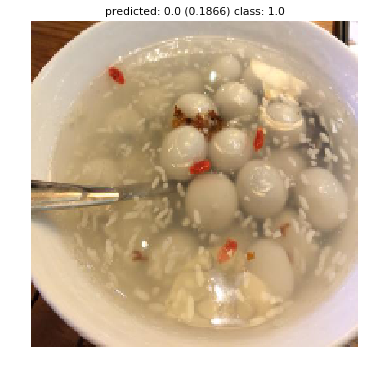

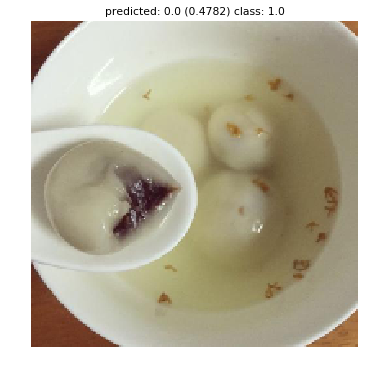

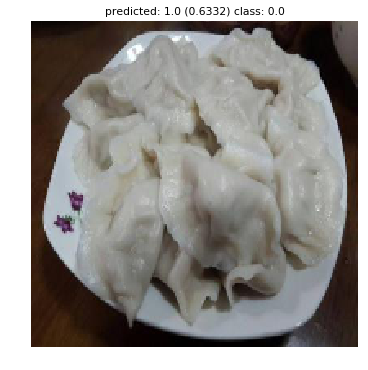

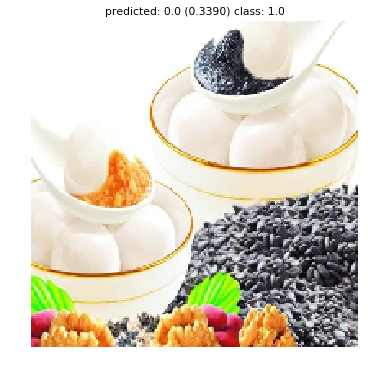

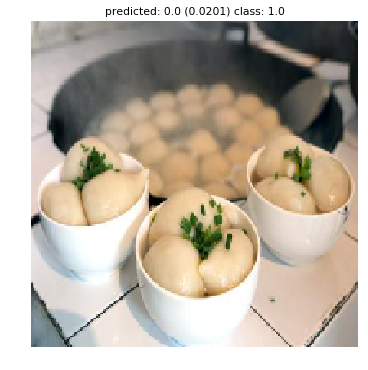

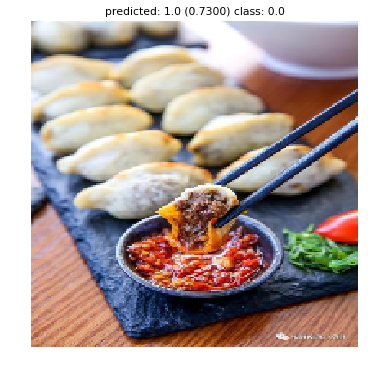

jiaozi   acc: 0.88
tangyuan acc: 0.87
total    acc: 0.88


In [15]:
# 分别看下两种类别的分类情况, 并打印出分类错误的图片

epochs = 0
max_epochs = 6
e0cnt, e1cnt, c0cnt, c1cnt = 0, 0, 0, 0
for data in test_generator:
    xs, ys = data
    for i, x in enumerate(xs):
        test_x = x.reshape((1,) + x.shape)
        p = best_model.predict(test_x)[0][0]
        c = 0. if p < 0.5 else 1.
        if c != ys[i]:
            plt.imshow(x)
            plt.title("predicted: {:.1f} ({:.4f}) class: {:.1f}".format(c, p, ys[i]))
            plt.axis('off')
            plt.show()
            if ys[i] == 1.:
                e1cnt += 1
            else:
                e0cnt += 1
        if ys[i] == 1.:
            c1cnt += 1
        else:
            c0cnt += 1
    epochs += 1
    if epochs == max_epochs:
        break
print "jiaozi   acc: {:.2f}".format(1-float(e0cnt)/c0cnt)
print "tangyuan acc: {:.2f}".format(1-float(e1cnt)/c1cnt)
print "total    acc: {:.2f}".format(1-float(e0cnt+e1cnt)/(c0cnt+c1cnt))

In [16]:
# 对于新图片的预测, 也可以使用 load_img -> imresize -> rescale -> reshape (增加一个维度) 的方式处理

total = 0.
e0cnt = 0.
for fn in os.listdir('data/test/jiaozi/'):
    img = load_img('data/test/jiaozi/' + fn)
    img = imresize(img, size=(img_height, img_width))
    test_x = img_to_array(img).reshape(img_height, img_width, 3)
    test_x = test_x / 255.
    test_x = test_x.reshape((1,) + test_x.shape)
    predicted = best_model.predict(test_x)[0][0]
    if predicted > 0.5:
        e0cnt += 1
    total += 1
print "jiaozi acc: {:.2f}".format(1-e0cnt/total)

jiaozi acc: 0.89
